In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import os

In [12]:
path = '/home/carnd/speech-recognition-kaggle/speech-data/'
test_list = []
valid_list = []
with open(path+'testing_list.txt') as testing_file:
    data = testing_file.readlines()
    for line in data:
        test_list.append(line.strip())
        
with open(path+'validation_list.txt') as testing_file:
    data = testing_file.readlines()
    for line in data:
        valid_list.append(line.strip())
        


In [13]:
classes = ['yes','no','up','down','left','right','on','off','stop','go',
           '_background_noise_','bed','bird','cat','dog','eight',
                  'five','four','happy','house','marvin','nine','one',
                  'seven','sheila','six','three','tree','two','wow','zero']
all_dir = []

for i in classes:
    for l in os.listdir(path+i):
        all_dir.append(i+'/'+l)

for data1,data2 in zip(test_list,valid_list):
    all_dir.remove(data1)
    all_dir.remove(data2)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


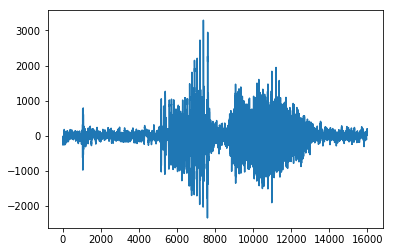

In [14]:
#import soundfile as sf
%matplotlib inline

classes = ['yes','no','up','down','left','right','on','off','stop','go']

unknown_classes = ['_background_noise_','bed','bird','cat','dog','eight',
                  'five','four','happy','house','marvin','nine','one',
                  'seven','sheila','six','three','tree','two','wow','zero']
X_train = []
y_train = []
X_test = []
y_test = []
X_valid = []
y_valid = []
rate = []
for l in all_dir:
    check = l.split('/')[0]
    try:
        data = read(path+l)
        rate.append(data[1].size)
        X_train.append(data[1])
        if check in classes:
            y_train.append(classes.index(check))
        else:
            y_train.append(10)
    except ValueError:
        continue
        
for l in valid_list:
    check = l.split('/')[0]
    try:
        data = read(path+l)
        X_valid.append(data[1])
        if check in classes:
            y_valid.append(classes.index(check))
        else:
            y_valid.append(10)
    except ValueError:
        continue
        
for l in test_list:
    check = l.split('/')[0]
    try:
        data = read(path+l)
        X_test.append(data[1])
        if check in classes:
            y_test.append(classes.index(check))
        else:
            y_test.append(10)
    except ValueError:
        continue
        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
X_test = np.array(X_test)
y_test = np.array(y_test)

plt.plot(range(X_train[0].size),X_train[0])

In [15]:
# Pre-emphasis
pre_emphasis= 0.97
rate = np.array(rate)
for x in range(len(X_train)):
    X_train[x][1:] = X_train[x][1:] - pre_emphasis * X_train[x][:-1]
for x in range(len(X_test)):
    X_test[x][1:] = X_test[x][1:] - pre_emphasis * X_test[x][:-1]
for x in range(len(X_valid)):
    X_valid[x][1:] = X_valid[x][1:] - pre_emphasis * X_valid[x][:-1]

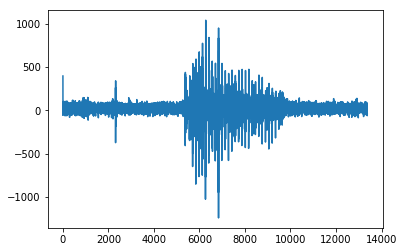

In [16]:
plt.plot(range(X_train[11685].size),X_train[11685])

In [17]:
def normalize(X_data):
    sample_rate = 16e3
    frame_size = 0.025
    frame_stride = 0.01
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    signal_length = 5000
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    frames  =[]
    for x in range(51131):
        pad_signal = np.append(X_data[x], z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
        indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
        frames_temp = pad_signal[indices.astype(np.int32, copy=False)]
        frames.append(frames_temp)
    
    
    frames = np.array(frames)
    # Windowing -> Hamming window
    frames *= np.hamming(frame_length)
    
    
    # FFT
    NFFT = 512
    mag_frames = frames.copy()
    pow_frames = frames.copy()
    for x in range(frames.shape[0]):
        mag_frames[x] = np.absolute(np.fft.rfft(frames[x], NFFT))  # Magnitude of the FFT
        pow_frames[x] = ((1.0 / NFFT) * ((mag_frames[x]) ** 2))  # Power Spectrum
        
        
    # Filter bank
    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = pow_frames.copy()
    for x in range(pow_frames.shape[0]):
        filter_banks[x] = np.dot(pow_frames[x], fbank.T)
        filter_banks[x] = np.where(filter_banks[x] == 0, np.finfo(float).eps, filter_banks[x])  # Numerical Stability
        filter_banks[x] = 20 * np.log10(filter_banks[x])  # dB    
        filter_banks[x] -= (np.mean(filter_banks[x], axis=0) + 1e-8)
        
    return filter_banks        

In [18]:
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

image = plt.imshow(X_train)
plt.show()

MemoryError: 

In [ ]:
# Model
def Len(x):
    mu = 0
    sigma = 0.1
    weights = {
        'w1': tf.Variable(tf.truncated_normal(shape=(5,5,1,6),mean=mu,stddev=sigma)),
        'w2': tf.Variable(tf.truncated_normal(shape=(5,5,6,16),mean=mu,stddev=sigma)),
        'w3': tf.Variable(tf.truncated_normal(shape=(400,120), mean=mu,stddev=sigma)),
        'w4': tf.Variable(tf.truncated_normal(shape=(120,84), mean=mu,stddev=sigma)),
        'w5': tf.Variable(tf.truncated_normal(shape=(84,10), mean=mu,stddev=sigma))
    }
    biases = {
        'b1': tf.Variable(tf.zeros(6)),
        'b2': tf.Variable(tf.zeros(16)),
        'b3': tf.Variable(tf.zeros(120)),
        'b4': tf.Variable(tf.zeros(84)),
        'b5': tf.Variable(tf.zeros(10))
    }
    
    # 1st layer, convolution and the max pool input 32x32x1, output from maxpool 14x14x6:
    conv1 = tf.nn.conv2d(x,weights['w1'],strides=[1,1,1,1],padding='VALID') + biases['b1']
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Next Layer, again convolution and the max pool input 14x14x16 to 5x5x16:
    conv2 = tf.nn.conv2d(conv1,weights['w2'],strides=[1,1,1,1],padding='VALID') + biases['b2']
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # flattening, input 5x5x16 to 400:
    f1 = flatten(conv2)
    
    # Fully connected, input 400x1, output 120
    fc1 = tf.add(tf.matmul(f1,weights['w3']),biases['b3'])
    fc1 = tf.nn.relu(fc1)
    
    # 2nd fullt connected, input 120 output 84
    fc2 = tf.add(tf.matmul(fc1,weights['w4']),biases['b4'])
    fc2 = tf.nn.relu(fc2)
    
    # Final output, input is 84, output 10
    fc3 = tf.add(tf.matmul(fc2,weights['w5']),biases['b5'])
    output = tf.nn.relu(fc3)
    
    return fc3

In [ ]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)

# These functions will train the model and modify the weights and biases:
logits = Len(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer()
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
saver = tf.train.Saver()


def validate(X_valid,y_valid):
    total_accuracy = 0
    sess = tf.get_default_session()
    for batch in range(0, len(X_valid), batch_size):
        batch_x, batch_y =  X_valid[batch:batch+batch_size],y_valid[batch:batch+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / len(X_valid)


batch_size = 128
epoch = 5

# Here, I will train the model by using the Adam optimizer. I have divided the samples to 128 size batches.
with tf.Session() as s:
    s.run(tf.global_variables_initializer())
    X_train, y_train = shuffle(X_train, y_train)
    for e in range(0,epoch):
        
        for batch in range(0,len(X_train),batch_size):
            X_batch,y_batch = X_train[batch:batch+batch_size],y_train[batch:batch+batch_size]
            s.run(training_operation, feed_dict={x:X_batch,y:y_batch}) 
        
        accuracy = validate(X_valid,y_valid)
        print("EPOCH {} ...".format(e+1))
        print("Validation Accuracy = {:.3f}".format(accuracy))
        print()
        
    saver.save(s, './lenet')
    print("Model saved")